In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from lob_data_utils import roc_results, gdf_pca
import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../gdf_pca/res_lstm_reg'
filename_pattern = 'res_lstm_unit_{}_len10000_r{}_s{}.csv'
data_regular_dir = '../queue_imbalance/data/prepared/'
stocks = list(roc_results.results_10000.keys())
data_length = 10000
should_save_fig = False

In [3]:
mid_prices = []
df_huge = pd.DataFrame()
for stock in stocks:
    df_reg, df_reg_test = lob.load_prepared_data(
        stock, data_dir=data_regular_dir, cv=False, length=data_length)
    mid_prices.append({
        'stock': int(stock), 'mid_price': df_reg['mid_price'].mean(), 
        'spread': (df_reg['ask_price'] - df_reg['bid_price']).mean(),
        'mid_price_negative': len(df_reg[df_reg['mid_price_indicator'] == 0]),
        'mid_price_positive': len(df_reg[df_reg['mid_price_indicator'] == 1])
    })
    #df_huge = df_huge.append(df_reg)
df_regular = pd.DataFrame(mid_prices)
df_regular.head()

,mid_price,mid_price_negative,mid_price_positive,spread,stock
0,280.159303,3916,4084,0.107444,9069
1,439.943869,3986,4014,0.100712,9063
2,449.038569,3908,4092,0.289588,1472
3,1538.635500,3990,4010,1.015375,9094
4,2143.956719,3976,4024,0.650312,9270


In [4]:
#df_huge.columns

In [5]:
# plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')

# sns.violinplot(y=df_huge['queue_imbalance'], x=df_huge['mid_price_indicator'], scale="count", split=True)

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')
# if should_save_fig:
#     plt.savefig('all_stocks_violin_plot_imb_vs_ind.png')

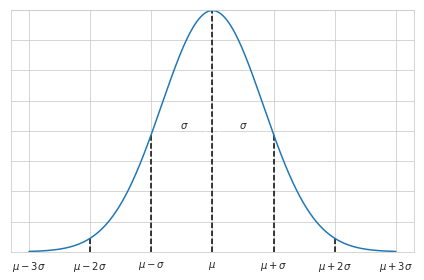

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-9, 9, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2.5))
plt.vlines(0, 0, 0.18, linestyles='dashed', label='mid price')
plt.vlines(3, 0, 0.078, linestyles='dashed')
plt.vlines(-3, 0, 0.078, linestyles='dashed')
plt.vlines(6, 0, 0.01, linestyles='dashed')
plt.vlines(-6, 0, 0.01, linestyles='dashed')
plt.annotate("", xytext=(-3, 0.078), xy=(0, 0.078), arrowprops=dict(arrowstyle="<->"), label='$\sigma$')
plt.annotate("", xytext=(0, 0.078), xy=(3, 0.078), arrowprops=dict(arrowstyle="<->"), label='$\sigma$')
plt.annotate('$\sigma$', xytext=(-1.6, 0.082), xy=(0, 0.082))
plt.annotate('$\sigma$', xytext=(1.3, 0.082), xy=(3, 0.082))
plt.ylim(0, 0.16)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False, 
    labelleft=False) 
my_xticks = ['$\mu - 3\sigma$', '$\mu - 2\sigma$', '$\mu - \sigma$', 
             '$\mu$', '$\mu + \sigma$', '$\mu + 2\sigma$', '$\mu + 3\sigma$']
a = plt.xticks([-9, -6, -3, 0, 3, 6, 9], my_xticks)
plt.tight_layout()
if should_save_fig:
    plt.savefig('gaussian.png')

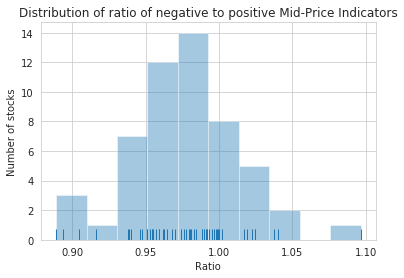

In [7]:
sns.distplot(df_regular['mid_price_negative'] / df_regular['mid_price_positive'], kde=False, rug=True)
plt.xlabel('Ratio')
plt.ylabel('Number of stocks')
plt.title('Distribution of ratio of negative to positive Mid-Price Indicators')
plt.savefig('ratio_mid_price_indicator.png')

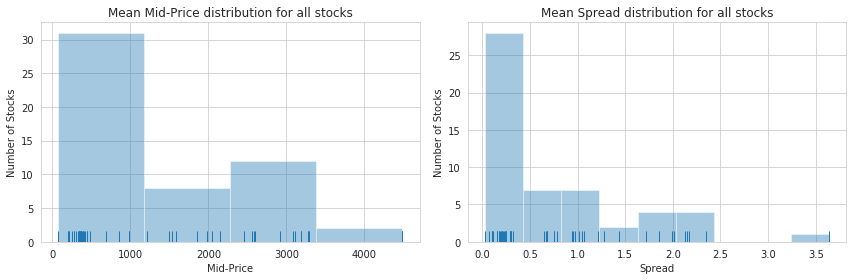

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_regular['mid_price'], kde=False, ax=ax1, rug=True)
ax1.set_xlabel('Mid-Price')
ax1.set_ylabel('Number of Stocks')
ax1.set_title('Mean Mid-Price distribution for all stocks')

sns.distplot(df_regular['spread'], kde=False, ax=ax2, rug=True)
ax2.set_xlabel('Spread')
ax2.set_ylabel('Number of Stocks')

ax2.set_title('Mean Spread distribution for all stocks')
plt.tight_layout()
plt.savefig('mid_price_distribution.png')


In [9]:
df_regular.columns

Index(['mid_price', 'mid_price_negative', 'mid_price_positive', 'spread',
       'stock'],
      dtype='object')

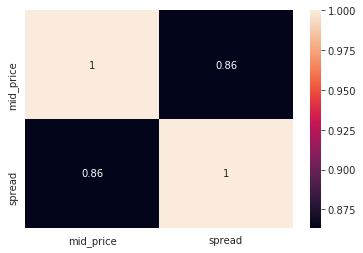

In [10]:
sns.heatmap(df_regular[['mid_price', 'spread']].corr(), annot=True)

Text(0.5,1,'Spread distribution for all stocks')

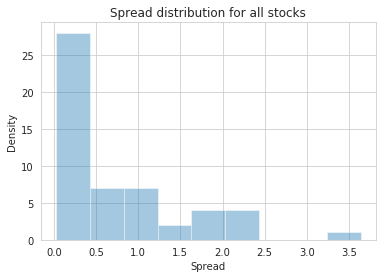

In [11]:
sns.distplot(df_regular['spread'], kde=False)
plt.xlabel('Spread')
plt.ylabel('Density')
plt.title('Spread distribution for all stocks')

In [12]:
df_regular[['mid_price', 'spread']].describe()

,mid_price,spread
count,53.000000,53.000000
mean,1338.327160,0.763437
std,1261.646819,0.785512
min,75.131704,0.026420
25%,352.897625,0.204388
50%,488.642700,0.302538
75%,2462.093375,1.048312
max,4486.275750,3.637750


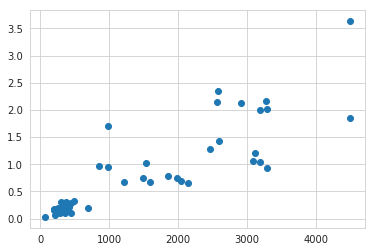

In [13]:
plt.scatter(df_regular['mid_price'], df_regular['spread'])

In [14]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    parts_of_filename = f.split('_')
    stock = parts_of_filename[5]
    r = parts_of_filename[7][1:]
    s = parts_of_filename[8][1:].split('.csv')[0]
    df_stock = pd.read_csv(os.path.join(data_dir, f))
    df_stock['stock'] = [int(stock)] * len(df_stock)
    df_stock['r'] = [float(r)] * len(df_stock)
    df_stock['s'] = [float(s)] * len(df_stock)
    df_res = df_res.append(df_stock)
df_res = df_res[df_res['hidden_layer'] == 1] # tODO:


In [15]:
df_res.columns

Index(['Unnamed: 0', 'f1', 'features', 'hidden_layer', 'kappa', 'kernel',
       'matthews', 'pca_components', 'precision', 'recall', 'regularization',
       'roc_auc', 'stock', 'test_f1', 'test_kappa', 'test_matthews',
       'test_precision', 'test_recall', 'test_roc_auc', 'train_f1',
       'train_kappa', 'train_matthews', 'train_precision', 'train_recall',
       'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'unit', 'r', 's'],
      dtype='object')

In [16]:
df_res = pd.merge(df_res, df_regular, on='stock')
df_res.columns

Index(['Unnamed: 0', 'f1', 'features', 'hidden_layer', 'kappa', 'kernel',
       'matthews', 'pca_components', 'precision', 'recall', 'regularization',
       'roc_auc', 'stock', 'test_f1', 'test_kappa', 'test_matthews',
       'test_precision', 'test_recall', 'test_roc_auc', 'train_f1',
       'train_kappa', 'train_matthews', 'train_precision', 'train_recall',
       'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'unit', 'r', 's', 'mid_price',
       'mid_price_negative', 'mid_price_positive', 'spread'],
      dtype='object')

In [17]:
columns = ['stock', 'r', 's', 'features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price', 'spread', 'unit']
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock', 'unit']).head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
0,11946,0.1,0.1,pca_n_gdf_que_prev,0.205720,0.600131,0.189568,0.594815,0.183897,0.591965,195.266563,0.172400,1
2,11946,0.1,0.1,pca_n_gdf_que_prev,0.202081,0.599408,0.184445,0.592296,0.181348,0.590687,195.266563,0.172400,6
1,11946,0.1,0.1,pca_n_gdf_que_prev,0.200897,0.598935,0.197503,0.598614,0.187740,0.593837,195.266563,0.172400,3
3,11946,0.1,0.1,pca_n_gdf_que_prev,0.200165,0.598431,0.199099,0.599291,0.185693,0.592730,195.266563,0.172400,20
122,3035,0.1,0.1,pca_n_gdf_que_prev,0.164315,0.581489,0.100575,0.549602,0.176339,0.587451,251.878844,0.196388,12
148,2813,0.1,0.1,pca_n_gdf_que_prev,0.161217,0.579875,0.093681,0.546563,0.142919,0.571004,383.283281,0.204388,1
34,12417,0.1,0.1,pca_n_gdf_que_prev,0.160687,0.578373,0.157726,0.578705,0.162132,0.581067,306.583788,0.300750,10
84,3879,0.1,0.1,pca_n_gdf_que_prev,0.160240,0.580013,0.118277,0.559092,0.174556,0.587201,2462.093375,1.281750,1
123,3035,0.1,0.1,pca_n_gdf_que_prev,0.160018,0.579224,0.099611,0.549168,0.175504,0.587122,251.878844,0.196388,20
150,2813,0.1,0.1,pca_n_gdf_que_prev,0.159716,0.579614,0.095172,0.547374,0.141228,0.570293,383.283281,0.204388,4


In [18]:
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)['unit'].value_counts()

20    16
4     12
1     10
6      4
2      3
10     2
8      2
14     1
12     1
7      1
3      1
Name: unit, dtype: int64

In [19]:
df_res[columns][df_res['s'] == 0.1].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
0,11946,0.1,0.1,pca_n_gdf_que_prev,0.205720,0.600131,0.189568,0.594815,0.183897,0.591965,195.266563,0.172400,1
122,3035,0.1,0.1,pca_n_gdf_que_prev,0.164315,0.581489,0.100575,0.549602,0.176339,0.587451,251.878844,0.196388,12
148,2813,0.1,0.1,pca_n_gdf_que_prev,0.161217,0.579875,0.093681,0.546563,0.142919,0.571004,383.283281,0.204388,1
34,12417,0.1,0.1,pca_n_gdf_que_prev,0.160687,0.578373,0.157726,0.578705,0.162132,0.581067,306.583788,0.300750,10
84,3879,0.1,0.1,pca_n_gdf_que_prev,0.160240,0.580013,0.118277,0.559092,0.174556,0.587201,2462.093375,1.281750,1
78,4799,0.1,0.1,pca_n_gdf_que_prev,0.158683,0.579003,0.125029,0.562455,0.141358,0.570681,979.559531,1.713688,4
204,7858,0.1,0.1,pca_n_gdf_que_prev,0.157733,0.578414,0.166718,0.582171,0.152027,0.575973,4486.275750,3.637750,1
156,1956,0.1,0.1,pca_n_gdf_que_prev,0.156639,0.573411,0.133866,0.566065,0.150742,0.574595,282.365775,0.156275,1
19,9086,0.1,0.1,pca_n_gdf_que_prev,0.156023,0.577471,0.119220,0.559612,0.131907,0.565904,217.865897,0.068819,20
107,10508,0.1,0.1,pca_n_gdf_que_prev,0.153577,0.576463,0.150077,0.575046,0.142119,0.571069,355.728538,0.245200,20


In [20]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_best

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
0,11946,0.1,0.1,pca_n_gdf_que_prev,0.205720,0.600131,0.189568,0.594815,0.183897,0.591965,195.266563,0.172400,1
122,3035,0.1,0.1,pca_n_gdf_que_prev,0.164315,0.581489,0.100575,0.549602,0.176339,0.587451,251.878844,0.196388,12
148,2813,0.1,0.1,pca_n_gdf_que_prev,0.161217,0.579875,0.093681,0.546563,0.142919,0.571004,383.283281,0.204388,1
34,12417,0.1,0.1,pca_n_gdf_que_prev,0.160687,0.578373,0.157726,0.578705,0.162132,0.581067,306.583788,0.300750,10
84,3879,0.1,0.1,pca_n_gdf_que_prev,0.160240,0.580013,0.118277,0.559092,0.174556,0.587201,2462.093375,1.281750,1
78,4799,0.1,0.1,pca_n_gdf_que_prev,0.158683,0.579003,0.125029,0.562455,0.141358,0.570681,979.559531,1.713688,4
204,7858,0.1,0.1,pca_n_gdf_que_prev,0.157733,0.578414,0.166718,0.582171,0.152027,0.575973,4486.275750,3.637750,1
156,1956,0.1,0.1,pca_n_gdf_que_prev,0.156639,0.573411,0.133866,0.566065,0.150742,0.574595,282.365775,0.156275,1
19,9086,0.1,0.1,pca_n_gdf_que_prev,0.156023,0.577471,0.119220,0.559612,0.131907,0.565904,217.865897,0.068819,20
107,10508,0.1,0.1,pca_n_gdf_que_prev,0.153577,0.576463,0.150077,0.575046,0.142119,0.571069,355.728538,0.245200,20


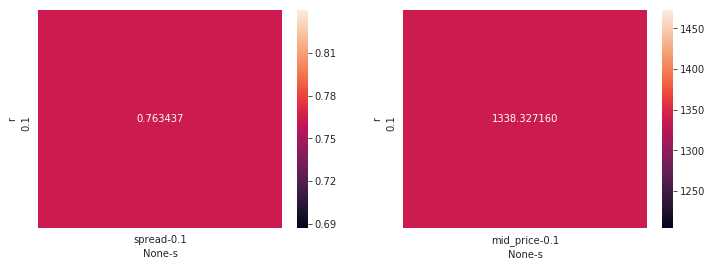

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df_best1 = df_best[['r', 's', 'spread']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax1)
df_best1 = df_best[['r', 's', 'mid_price']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax2)

In [22]:
# mean 1338.327160 0.763437

df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['matthews'].mean()

nan

In [23]:
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.10199070413831153

In [24]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

nan

In [25]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

nan

In [26]:
df_best['r'].value_counts(), df_best['s'].value_counts()

(0.1    53
 Name: r, dtype: int64, 0.1    53
 Name: s, dtype: int64)

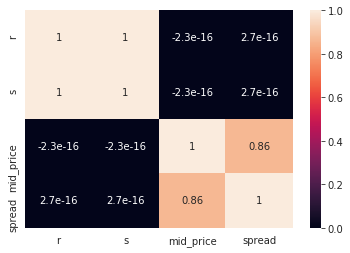

In [27]:
sns.heatmap(df_best[['r', 's', 'mid_price', 'spread']].corr(), annot=True)

,test_matthews,matthews,test_roc_auc,roc_auc
count,53.000000,53.000000,53.000000,53.000000
mean,0.115218,0.131272,0.556864,0.564515
std,0.029788,0.024258,0.014892,0.011964
min,0.054849,0.068945,0.527234,0.534454
25%,0.091660,0.117069,0.545267,0.558001
50%,0.116305,0.131264,0.555134,0.564751
75%,0.140358,0.146072,0.566507,0.572149
max,0.189568,0.205720,0.594815,0.600131


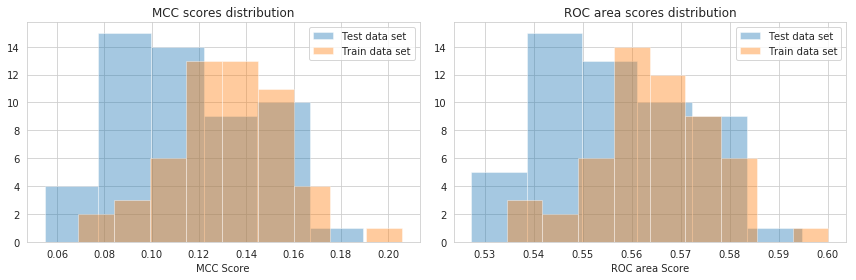

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_best['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_best['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_best['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_best['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
plt.savefig('results_mlp_pca_score_dist.png')

df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

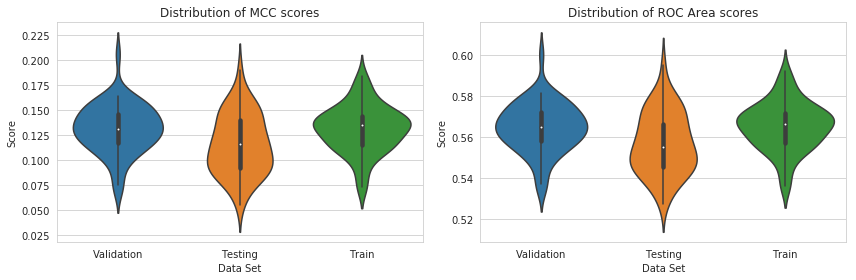

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df = df_best.copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's',  'features', 'spread', 'mid_price', 
                   'roc_auc', 'test_roc_auc', 'train_roc_auc', 'unit'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best.copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's', 'features', 'spread', 'mid_price', 
                   'matthews', 'test_matthews', 'train_matthews', 'unit'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')
plt.tight_layout()
plt.savefig('violin_distribution_scores_mlp.png')

In [30]:
print(df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  test\_matthews &   matthews &  test\_roc\_auc &    roc\_auc \\
\midrule
count &      53.000000 &  53.000000 &     53.000000 &  53.000000 \\
mean  &       0.115218 &   0.131272 &      0.556864 &   0.564515 \\
std   &       0.029788 &   0.024258 &      0.014892 &   0.011964 \\
min   &       0.054849 &   0.068945 &      0.527234 &   0.534454 \\
25\%   &       0.091660 &   0.117069 &      0.545267 &   0.558001 \\
50\%   &       0.116305 &   0.131264 &      0.555134 &   0.564751 \\
75\%   &       0.140358 &   0.146072 &      0.566507 &   0.572149 \\
max   &       0.189568 &   0.205720 &      0.594815 &   0.600131 \\
\bottomrule
\end{tabular}



In [31]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

df_log = pd.read_csv('../gdf_pca/res_log_que.csv')
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])

In [32]:
df = df_best.copy()
columns = ['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log']

df['test_matthews_diff'] = df['test_matthews'] - df['test_matthews_log']
df['train_matthews_diff'] = df['train_matthews'] - df['train_matthews_log']
df['validation_matthews_diff'] = df['matthews'] - df['matthews_log']
df['test_roc_auc_diff'] = df['test_roc_auc'] - df['test_roc_auc_log']
df['train_roc_auc_diff'] = df['train_roc_auc'] - df['train_roc_auc_log']
df['validation_roc_auc_diff'] = df['roc_auc'] - df['roc_auc_log']

print(df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  test\_matthews\_diff &  train\_matthews\_diff &  validation\_matthews\_diff &  test\_roc\_auc\_diff &  train\_roc\_auc\_diff &  validation\_roc\_auc\_diff \\
\midrule
count &           53.000000 &            53.000000 &                 53.000000 &          53.000000 &           53.000000 &                53.000000 \\
mean  &           -0.002115 &             0.003516 &                  0.001562 &          -0.001230 &            0.001702 &                 0.000802 \\
std   &            0.013075 &             0.006196 &                  0.009836 &           0.006375 &            0.003222 &                 0.005100 \\
min   &           -0.037458 &            -0.004257 &                 -0.021571 &          -0.019358 &           -0.003697 &                -0.011054 \\
25\%   &           -0.008497 &            -0.000558 &                 -0.004415 &          -0.004209 &           -0.000264 &                -0.001933 \\
50\%   &           -0.004180 &  

In [33]:
df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe()

,test_matthews_diff,train_matthews_diff,validation_matthews_diff,test_roc_auc_diff,train_roc_auc_diff,validation_roc_auc_diff
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,-0.002115,0.003516,0.001562,-0.001230,0.001702,0.000802
std,0.013075,0.006196,0.009836,0.006375,0.003222,0.005100
min,-0.037458,-0.004257,-0.021571,-0.019358,-0.003697,-0.011054
25%,-0.008497,-0.000558,-0.004415,-0.004209,-0.000264,-0.001933
50%,-0.004180,0.002142,0.000581,-0.001086,0.001223,-0.000563
75%,0.006867,0.006285,0.009017,0.003462,0.002815,0.004920
max,0.033246,0.023828,0.022371,0.014132,0.011442,0.010747


In [34]:
print(df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count())
print(df[df['train_matthews_diff'] > 0]['stock'].count(), df[df['train_roc_auc_diff'] > 0]['stock'].count())
print(df[df['validation_matthews_diff'] > 0]['stock'].count(), df[df['validation_roc_auc_diff'] > 0]['stock'].count())

22 22
37 37
28 26


In [35]:
df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count()

(22, 22)

## Results by r s using the alg

In [36]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()

4


,stock,r,s,cat,matthews,matthews_log,test_matthews,test_matthews_log,train_matthews,mid_price,spread
0,9074,0.1,0.1,1.0,0.145478,0.123107,0.099533,0.066287,0.134827,2043.858406,0.683562
1,9065,0.1,0.1,1.0,0.128653,0.131298,0.143079,0.122369,0.112190,1585.332719,0.665438
2,11583,0.1,0.1,1.0,0.115799,0.114770,0.117043,0.110154,0.111409,1979.635000,0.752625
3,9270,0.1,0.1,1.0,0.115362,0.100080,0.083981,0.068277,0.136363,2143.956719,0.650312
4,9266,0.1,0.1,1.0,0.095353,0.099768,0.090774,0.095205,0.111940,1493.420219,0.752812


In [37]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()

10


,stock,r,s,cat,matthews,matthews_log,test_matthews,test_matthews_log,train_matthews,mid_price,spread
0,9074,0.1,0.1,1.0,0.145478,0.123107,0.099533,0.066287,0.134827,2043.858406,0.683562
1,9065,0.1,0.1,1.0,0.128653,0.131298,0.143079,0.122369,0.112190,1585.332719,0.665438
2,11583,0.1,0.1,1.0,0.115799,0.114770,0.117043,0.110154,0.111409,1979.635000,0.752625
3,9270,0.1,0.1,1.0,0.115362,0.100080,0.083981,0.068277,0.136363,2143.956719,0.650312
4,9266,0.1,0.1,1.0,0.095353,0.099768,0.090774,0.095205,0.111940,1493.420219,0.752812


In [38]:
c = ['stock', 'r', 's', 'train_matthews', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log',  'mid_price', 'spread']
df_best[df_best['matthews'] > df_best['train_matthews'] + 0.02][c]

,stock,r,s,train_matthews,matthews,matthews_log,test_matthews,test_matthews_log,mid_price,spread
0,11946,0.1,0.1,0.183897,0.205720,0.201987,0.189568,0.206865,195.266563,0.172400
8,9086,0.1,0.1,0.131907,0.156023,0.148086,0.119220,0.132822,217.865897,0.068819
